In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_image_orig = cv2.imread('/home/abhi/Image Datasets/Assignment3/Panorama/institute2.jpg')
query_image_orig = cv2.imread('/home/abhi/Image Datasets/Assignment3/Panorama/institute1.jpg')

In [3]:
train_image = cv2.cvtColor(train_image_orig,cv2.COLOR_BGR2GRAY)
query_image = cv2.cvtColor(query_image_orig,cv2.COLOR_BGR2GRAY)

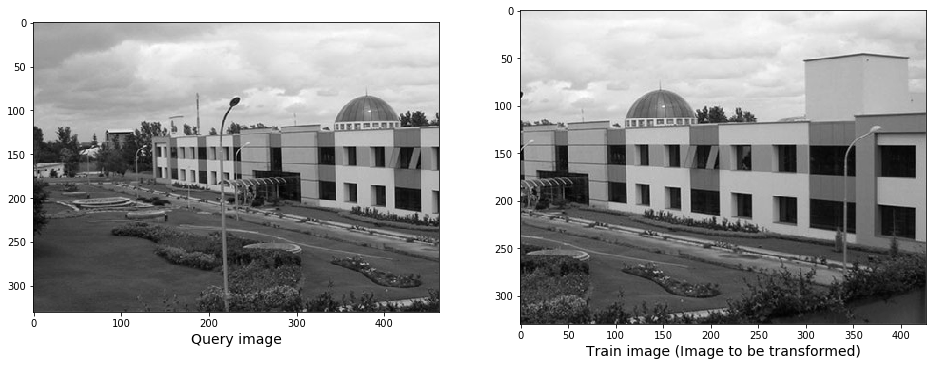

In [4]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(query_image, cmap="gray")
ax1.set_xlabel("Query image", fontsize=14)

ax2.imshow(train_image, cmap="gray")
ax2.set_xlabel("Train image (Image to be transformed)", fontsize=14)

plt.show()

In [5]:
#detecting keypoints using sift
sift = cv2.xfeatures2d.SIFT_create()
kp1,des1 = sift.detectAndCompute(train_image,None)
kp2,des2 = sift.detectAndCompute(query_image,None)

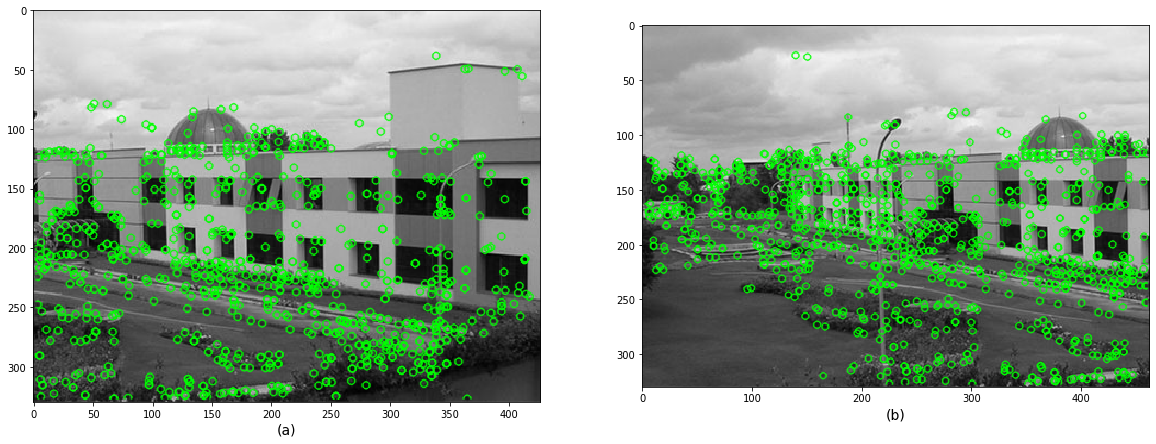

In [6]:
# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(train_image.copy(),kp1,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(query_image.copy(),kp2,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

plt.show()

In [7]:
# Creating Brute Force matcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
bf_matches = bf.match(des1,des2)
bf_matches = sorted(bf_matches, key = lambda x:x.distance)
print("Raw matches (Brute force):", len(bf_matches))
img_bf_match = cv2.drawMatches(train_image,kp1,query_image,kp2,bf_matches[:50],None,flags=2)

Raw matches (Brute force): 587


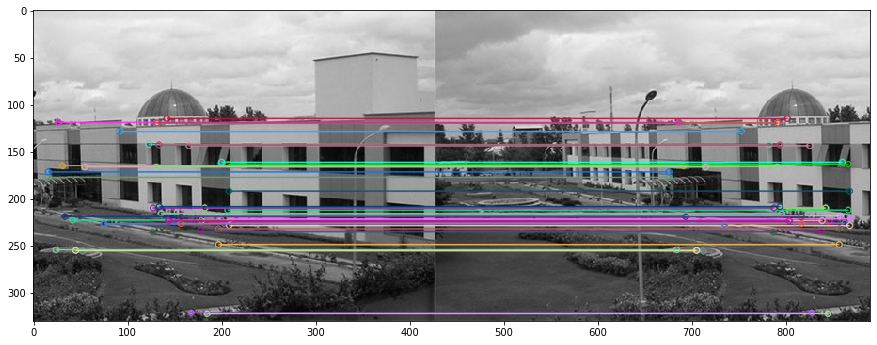

In [8]:
# Showing matches obtained using brute force matcher
plt.figure(figsize=(15,16))
plt.imshow(img_bf_match)

In [9]:
# Creating Knn matcher
bf = cv2.BFMatcher(cv2.NORM_L2,crossCheck=False)
knn_matches = bf.knnMatch(des1,des2,k=2,mask=None)
print("Raw Knn matches (Knn):", len(knn_matches))
#Performing ratio test ratio = 0.75 : if match1 distance is less than 75% of match2's distance 
#then only we comsider it good

good = []
for match1,match2 in knn_matches:
    if match1.distance < 0.75*match2.distance:
        good.append(match1)
print("Good Knn matches (Knn):", len(good))        

Raw Knn matches (Knn): 844
Good Knn matches (Knn): 413


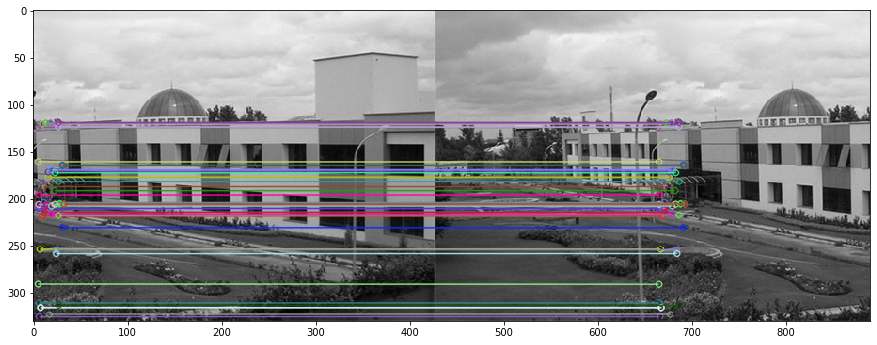

In [10]:
# Showing matches obtained using Knn matcher
img_bf_match = cv2.drawMatches(train_image,kp1,query_image,kp2,good[:50],None,flags=2)
plt.figure(figsize=(15,16))
plt.imshow(img_bf_match)

In [11]:
# Using FLANN Matcher
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

In [12]:
flann = cv2.FlannBasedMatcher(index_params,search_params)
flann_matches = flann.knnMatch(des1,des2,k=2)

#Performing ratio test ratio = 0.75
good_flann = []
for match1,match2 in flann_matches:
    if match1.distance < 0.75*match2.distance:
        good_flann.append(match1)
print("FLANN matches:", len(good_flann))        

FLANN matches: 413


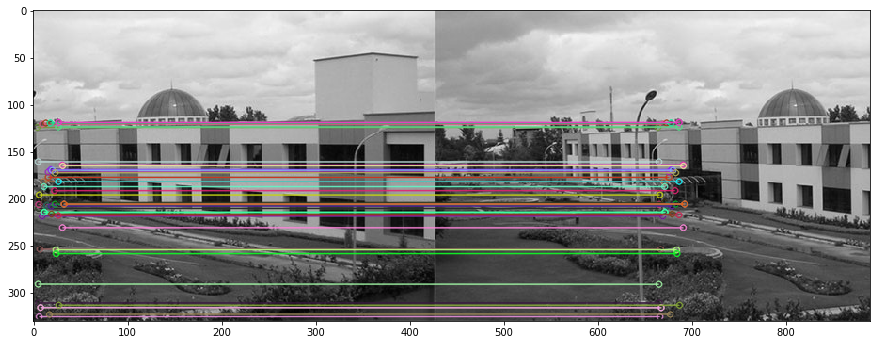

In [13]:
# Showing matches (just 50) obtained using FLANN-Knn matcher
img_flann_match = cv2.drawMatches(train_image,kp1,query_image,kp2,good_flann[:50],None,flags=2)
plt.figure(figsize=(15,16))
plt.imshow(img_flann_match)

In [14]:
def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    print(type(kpsA))
    if len(matches) > 4:
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,reprojThresh)
        return (matches, H, status)
    else:
        return None

In [15]:
# Getting homography matrics using Brute Force matches
bf_M = getHomography(kp1, kp2, des1, des2, bf_matches, reprojThresh=4)
if bf_M is None:
    print("Error!")
(matches, bf_H, bf_status) = bf_M
print(bf_H)

<class 'numpy.ndarray'>
[[ 1.00200819e+00 -2.15081688e-04  2.32937691e+02]
 [ 1.15743221e-03  1.00026091e+00 -1.12468848e-01]
 [ 4.85392656e-06 -8.69647683e-07  1.00000000e+00]]


In [16]:
# Getting homography matrics using KNN matches
knn_M = getHomography(kp1, kp2, des1, des2, good, reprojThresh=4)
if knn_M is None:
    print("Error!")
(matches, knn_H, bf_status) = knn_M
print(knn_H)

<class 'numpy.ndarray'>
[[ 9.99919243e-01  2.07846199e-04  2.32961069e+02]
 [ 1.39185590e-05  1.00019137e+00 -5.06735152e-02]
 [ 1.14269694e-07  2.02455353e-08  1.00000000e+00]]


In [17]:
# Getting homography matrics using FLANN-KNN matches
flann_M = getHomography(kp1, kp2, des1, des2, good_flann, reprojThresh=4)
if flann_M is None:
    print("Error!")
(matches, flann_H, flann_status) = flann_M
print(flann_H)

<class 'numpy.ndarray'>
[[ 9.99919243e-01  2.07846199e-04  2.32961069e+02]
 [ 1.39185590e-05  1.00019137e+00 -5.06735152e-02]
 [ 1.14269694e-07  2.02455353e-08  1.00000000e+00]]


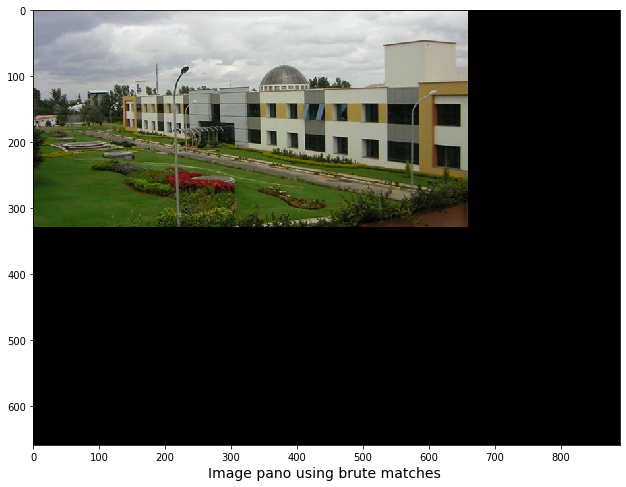

In [18]:
# Apply panorama correction 
width = train_image.shape[1] + query_image.shape[1]
height = train_image.shape[0] + query_image.shape[0]

result = cv2.warpPerspective(train_image_orig, bf_H, (width, height))
result[0:query_image.shape[0], 0:query_image.shape[1]] = query_image_orig

fig,axs1 = plt.subplots(1,1,figsize=(12,8))
axs1.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB),cmap='gray')
axs1.set_xlabel("Image pano using brute matches ",fontSize = 14)
plt.show()

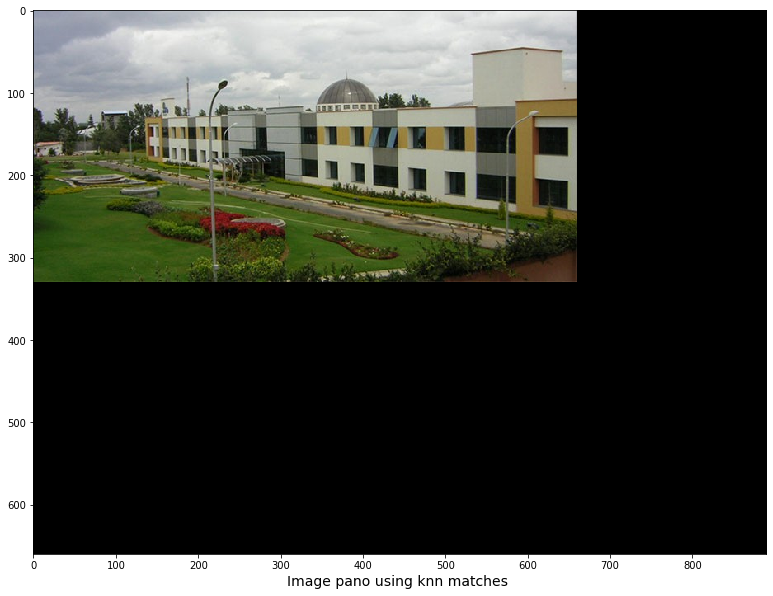

In [19]:
# Apply panorama correction
width = train_image.shape[1] + query_image.shape[1]
height = train_image.shape[0] + query_image.shape[0]

result = cv2.warpPerspective(train_image_orig, knn_H, (width, height))
result[0:query_image.shape[0], 0:query_image.shape[1]] = query_image_orig

fig,axs1 = plt.subplots(1,1,figsize=(20,10))
axs1.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB),cmap='gray')
axs1.set_xlabel("Image pano using knn matches ",fontSize = 14)
plt.show()

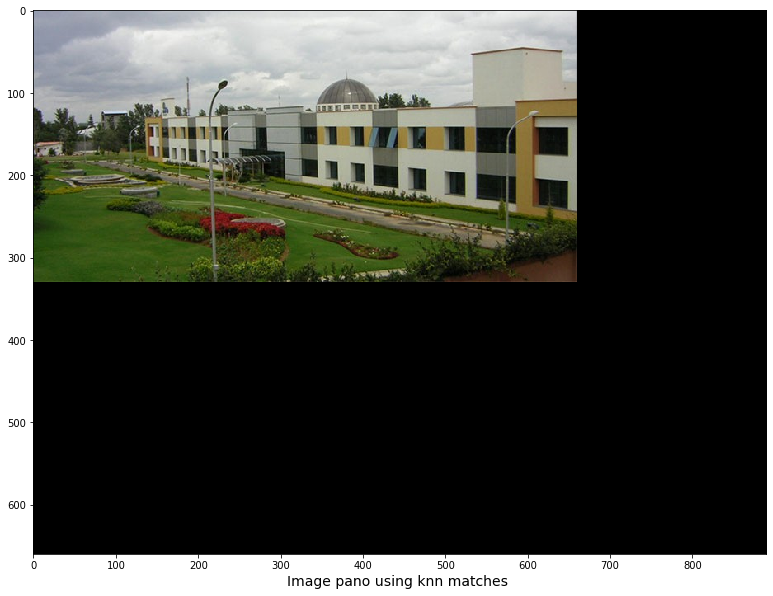

In [20]:
# Apply panorama correction
width = train_image.shape[1] + query_image.shape[1]
height = train_image.shape[0] + query_image.shape[0]

result = cv2.warpPerspective(train_image_orig, flann_H, (width, height))
result[0:query_image.shape[0], 0:query_image.shape[1]] = query_image_orig

fig,axs1 = plt.subplots(1,1,figsize=(20,10))
axs1.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB),cmap='gray')
axs1.set_xlabel("Image pano using knn matches ",fontSize = 14)
plt.show()

In [21]:
def trim(frame):
    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop bottom
    elif not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop left
    elif not np.sum(frame[:,0]):
        return trim(frame[:,1:]) 
    #crop right
    elif not np.sum(frame[:,-1]):
        return trim(frame[:,:-2])    
    return frame

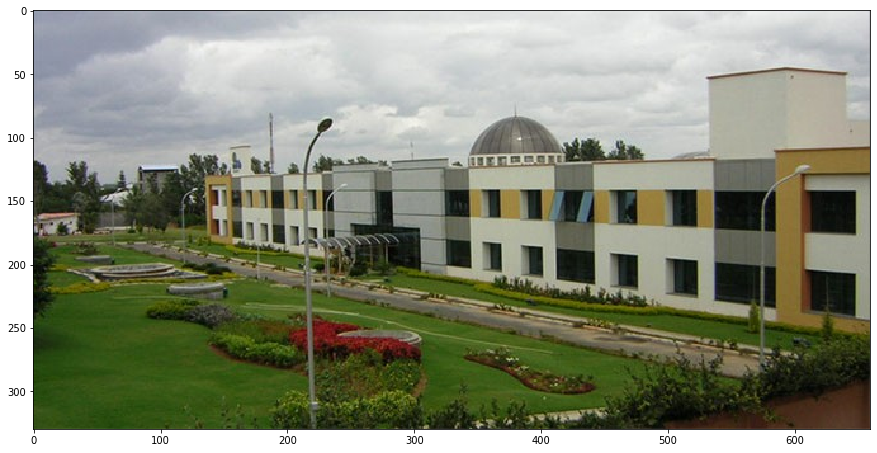

In [22]:
plt.figure(figsize=(15,16))
result_crop = trim(result)
plt.imshow(cv2.cvtColor(result_crop,cv2.COLOR_BGR2RGB))

In [23]:
cv2.imwrite("original_image_stitched_crop1.jpg", result_crop)

True